In [ ]:
#initial code

In [37]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
import xml.etree.ElementTree as ET
import timeit
from time import time
import math
import seaborn as sns

In [2]:
# Function to parse the XML file and extract city data
def parse_xml(xml_file):
    city_data = []
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for vertex_elem in root.findall(".//vertex"):
        edge_costs = [float(edge.get("cost")) for edge in vertex_elem]
        city_data.append(edge_costs)

    return city_data

In [3]:
 cities = parse_xml("burma14.xml")

In [43]:
#cities = parse_xml("brazil58.xml")

In [4]:
for i, vertex in enumerate(cities, start=1):
        print(f"Vertex {i} - Edge Costs: {vertex}")

Vertex 1 - Edge Costs: [153.0, 510.0, 706.0, 966.0, 581.0, 455.0, 70.0, 160.0, 372.0, 157.0, 567.0, 342.0, 398.0]
Vertex 2 - Edge Costs: [153.0, 422.0, 664.0, 997.0, 598.0, 507.0, 197.0, 311.0, 479.0, 310.0, 581.0, 417.0, 376.0]
Vertex 3 - Edge Costs: [510.0, 422.0, 289.0, 744.0, 390.0, 437.0, 491.0, 645.0, 880.0, 618.0, 374.0, 455.0, 211.0]
Vertex 4 - Edge Costs: [706.0, 664.0, 289.0, 491.0, 265.0, 410.0, 664.0, 804.0, 1070.0, 768.0, 259.0, 499.0, 310.0]
Vertex 5 - Edge Costs: [966.0, 997.0, 744.0, 491.0, 400.0, 514.0, 902.0, 990.0, 1261.0, 947.0, 418.0, 635.0, 636.0]
Vertex 6 - Edge Costs: [581.0, 598.0, 390.0, 265.0, 400.0, 168.0, 522.0, 634.0, 910.0, 593.0, 19.0, 284.0, 239.0]
Vertex 7 - Edge Costs: [455.0, 507.0, 437.0, 410.0, 514.0, 168.0, 389.0, 482.0, 757.0, 439.0, 163.0, 124.0, 232.0]
Vertex 8 - Edge Costs: [70.0, 197.0, 491.0, 664.0, 902.0, 522.0, 389.0, 154.0, 406.0, 133.0, 508.0, 273.0, 355.0]
Vertex 9 - Edge Costs: [160.0, 311.0, 645.0, 804.0, 990.0, 634.0, 482.0, 154.0, 2

In [5]:
# Calculate the total distance of a tour
def tour_distance(tour, distances):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distances[tour[i]][tour[i + 1]]
    total_distance += distances[tour[-1]][tour[0]]  # Return to the starting city
    return total_distance

In [60]:
# Generate an initial population of random tours
def generate_population(num_individuals, num_cities):
    population = []
    for _ in range(num_individuals):
        tour = list(range(num_cities))
        random.shuffle(tour)
        population.append(tour)
    return population

In [7]:
# Perform single-point crossover
def crossover_fixed_point(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-1)
    child1 = parent1[:crossover_point] + [c for c in parent2 if c not in parent1[:crossover_point]]
    child2 = parent2[:crossover_point] + [c for c in parent1 if c not in parent2[:crossover_point]]
    return child1, child2


In [51]:
def crossover_ordered (parent1, parent2):

    size = len(parent1)

    # Choose random start/end position for crossover
    child1, child2 = [-1] * size, [-1] * size
    start, end = sorted([random.randrange(size) for _ in range(2)])


    child1_inherited = []
    child2_inherited = []
    for i in range(start, end + 1):
        child1[i] = parent1[i]
        child2[i] = parent2[i]
        child1_inherited.append(parent1[i])
        child2_inherited.append(parent2[i])

    #print(child1, child2)
  
    current_parent2_position, current_parent1_position = 0, 0

    fixed_pos = list(range(start, end + 1))       
    i = 0
    while i < size:
        if i in fixed_pos:
            i += 1
            continue

        test_child1 = child1[i]
        if test_child1==-1: #to be filled
            parent2_trait = parent2[current_parent2_position]
            while parent2_trait in child1_inherited:
                current_parent2_position += 1
                parent2_trait = parent2[current_parent2_position]
            child1[i] = parent2_trait
            child1_inherited.append(parent2_trait)


        i +=1

        
        test_child2 = child2[i]
        if test_child2==-1: #to be filled
            parent1_trait = parent1[current_parent1_position]
            while parent1_trait in child2_inherited:
                current_parent1_position += 1
                parent1_trait = parent1[current_parent1_position]
            child2[i] = parent1_trait
            child2_inherited.append(parent1_trait)
            

            child1 = child1_inherited

            child2= child2_inherited

    return child1, child2

In [8]:
# Perform swap mutation
def swap_mutation(individual):
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
    return individual

In [52]:
# EA main loop

def evolutionary_algorithm(cities, num_generations, population_size, mutation_rate):
    
    num_cities = len(cities)
    distances = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distances[i][j] = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))

    population = generate_population(population_size, num_cities)
    best_distance = 9999999
    best_tour = None
    distances_log = []

    for generation in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = crossover_fixed_point(parent1, parent2)
            if random.random() < mutation_rate:
                child1 = swap_mutation(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
        # Calculate and store the best distance in each generation
        for individual in population:
            distance = tour_distance(individual, distances)
            if distance < best_distance:
                best_distance = distance
                best_tour = individual
        distances_log.append(best_distance)

    return best_tour, best_distance, distances_log


In [53]:
# Set EA parameters
num_generations = 10000
population_size = 50
mutation_rate = 0.1

iterations = [i for i in range(0,num_generations)]
iteration_db = pd.DataFrame({'iterations':iterations})

t0 = time()
    
best_tour,best_distance,distances_log =evolutionary_algorithm(cities, num_generations, population_size, mutation_rate)

t1 = time()

iteration_db['min_distance']=distances_log

In [54]:
iteration_db

,iterations,min_distance
0,0,13384.291524
1,1,13384.291524
2,2,13384.291524
3,3,13384.291524
4,4,13384.291524
...,...,...
9995,9995,10570.259429
9996,9996,10570.259429
9997,9997,10570.259429
9998,9998,10570.259429


In [55]:
# EA main loop

def evolutionary_algorithm2(cities, num_generations, population_size, mutation_rate):
    
    num_cities = len(cities)
    distances = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distances[i][j] = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))

    population = generate_population(population_size, num_cities)
    best_distance = 9999999
    best_tour = None
    distances_log = []

    for generation in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = crossover_ordered(parent1, parent2)
            if random.random() < mutation_rate:
                child1 = swap_mutation(child1)
            if random.random() < mutation_rate:
                child2 = swap_mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
        # Calculate and store the best distance in each generation
        for individual in population:
            distance = tour_distance(individual, distances)
            if distance < best_distance:
                best_distance = distance
                best_tour = individual
        distances_log.append(best_distance)

    return best_tour, best_distance, distances_log


In [56]:
# Set EA parameters
num_generations = 10000
population_size = 50
mutation_rate = 0.1

iterations1 = [i for i in range(0,num_generations)]
iteration_db1 = pd.DataFrame({'iterations':iterations})

t0 = time()
    
best_tour,best_distance,distances_log =evolutionary_algorithm2(cities, num_generations, population_size, mutation_rate)

t1 = time()

iteration_db1['min_distance']=distances_log


IndexError: list index out of range

In [ ]:
iteration_db1

KeyError: 'min_distance'

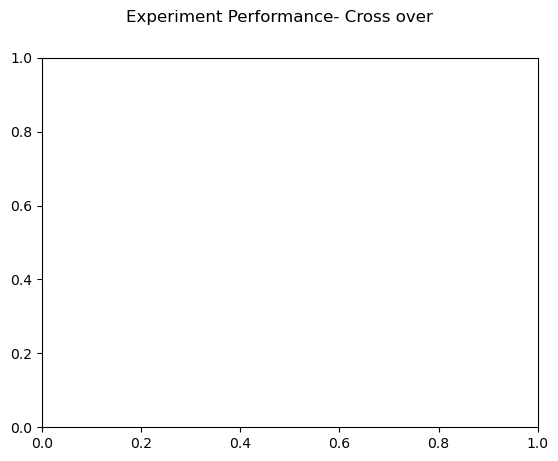

In [63]:
 # Plot convergence curve
    
fig, (ax2) = plt.subplots(1)
fig.suptitle('Experiment Performance- Cross over ')
ax2.plot(iterations, iteration_db1['min_distance'])
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.title("Convergence Curve")
plt.show()


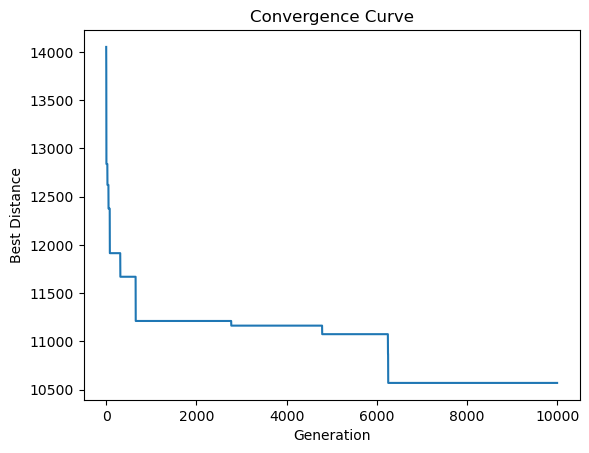

Best Tour: [0, 1, 7, 10, 8, 12, 11, 13, 6, 5, 2, 3, 4, 9]
Best Distance: 10569.695318265945


In [13]:
plt.plot(distances_log)
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.title("Convergence Curve")
plt.show()
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)

#Brazil:

In [14]:
print ('Evelotionary algorithm takes %f' %(t1-t0)+ ' seconds')

Evelotionary algorithm takes 5.912429 seconds
